<a href="https://colab.research.google.com/github/keeprich/AI-Trading-Bot/blob/main/ml_auto_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install oandapyV20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=3466de056257bc60d6f1096332cb6ed55697695cc55b4026abf136c976727321
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import oandapyV20

# Initialize OANDA API

API_KEY = "7881b59039beb34197d5c0d3d16f0a7a-fa4ffbfebacce78af23ec0227bef49bd"
ACCOUNT_ID = "101-004-30239848-002"
api = API(access_token=API_KEY)

def fetch_price_data(instrument, granularity, count=500):
    params = {"granularity": granularity, "count": count}
    candles = InstrumentsCandles(instrument=instrument, params=params)
    data = api.request(candles)
    prices = []
    for candle in data["candles"]:
        prices.append({
            "time": candle["time"],
            "open": float(candle["mid"]["o"]),
            "high": float(candle["mid"]["h"]),
            "low": float(candle["mid"]["l"]),
            "close": float(candle["mid"]["c"])
        })
    df = pd.DataFrame(prices)
    df["time"] = pd.to_datetime(df["time"])
    return df


In [ ]:
# feature Engineering

def calculate_features(df):
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()
    df['%K'] = ((df['close'] - df['low'].rolling(window=5).min()) /
               (df['high'].rolling(window=5).max() - df['low'].rolling(window=5).min())) * 100
    df['%D'] = df['%K'].rolling(window=3).mean()
    df['returns'] = df['close'].pct_change()
    df['volatility'] = df['returns'].rolling(window=10).std()

    # Drop NaN values
    df.dropna(inplace=True)
    return df


In [ ]:
# Label creation
def create_labels(df, threshold=0.002):  # 0.2% price change
    df['future_close'] = df['close'].shift(-5)  # Predicting 5 periods ahead
    df['label'] = np.where(df['future_close'] > df['close'] * (1 + threshold), 1,
                           np.where(df['future_close'] < df['close'] * (1 - threshold), -1, 0))
    df.drop(columns=['future_close'], inplace=True)
    return df


In [ ]:
# Model training

# Fetch and prepare data
df = fetch_price_data("EUR_USD", "H1")  # Example: EUR/USD on H1 timeframe
df = calculate_features(df)
df = create_labels(df)

# Define features and target
features = ['EMA_50', 'EMA_200', '%K', '%D', 'returns', 'volatility']
X = df[features]
y = df['label']

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.33      0.05      0.09        20
           0       0.58      0.80      0.68        61
           1       0.09      0.06      0.07        17

    accuracy                           0.52        98
   macro avg       0.34      0.30      0.28        98
weighted avg       0.45      0.52      0.45        98



In [ ]:
# real time prediction with visalisation

import matplotlib.pyplot as plt

def predict_and_plot(df):
    # Use model to predict on the latest data
    features = df[['EMA_50', 'EMA_200', '%K', '%D', 'returns', 'volatility']].tail(1)
    prediction = model.predict(features)[0]

    # Plot recent price data with indicators
    plt.figure(figsize=(14, 8))
    plt.plot(df['time'], df['close'], label="Close Price")
    plt.plot(df['time'], df['EMA_50'], label="EMA 50", linestyle="--")
    plt.plot(df['time'], df['EMA_200'], label="EMA 200", linestyle="--")
    plt.scatter(df['time'].tail(1), df['close'].tail(1), color='green' if prediction == 1 else 'red' if prediction == -1 else 'gray')
    plt.title(f"Prediction: {'BUY' if prediction == 1 else 'SELL' if prediction == -1 else 'HOLD'}")
    plt.legend()
    plt.show()

    return prediction


Fetching and analyzing data...


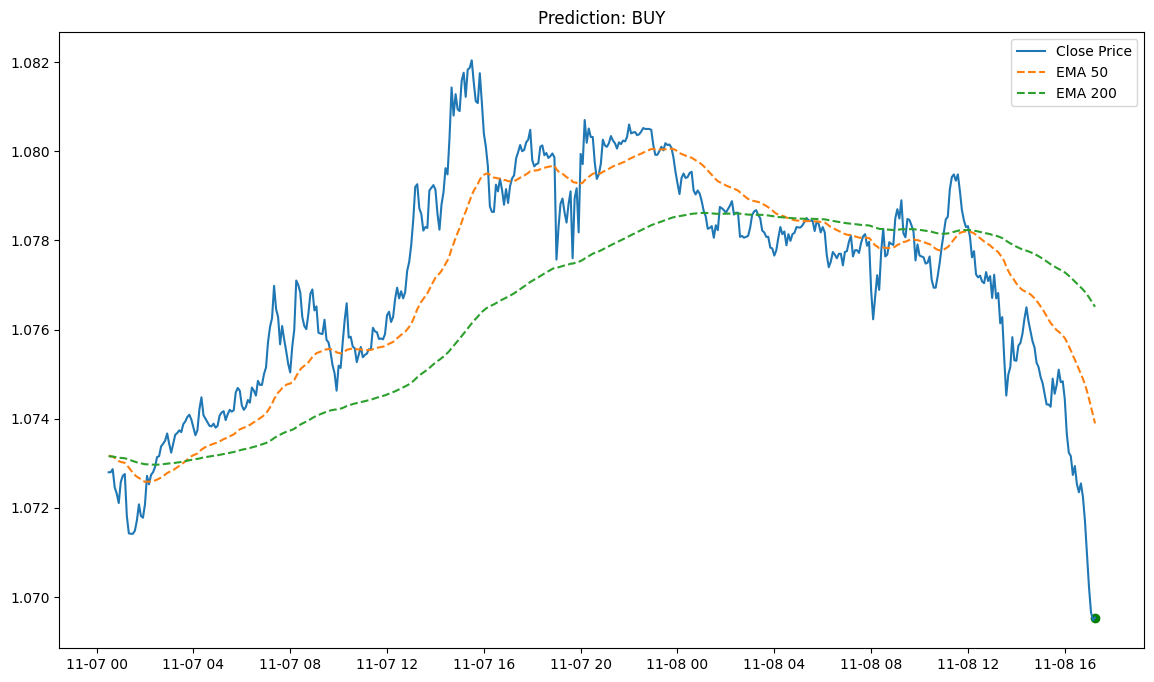

Prediction: BUY
Fetching and analyzing data...


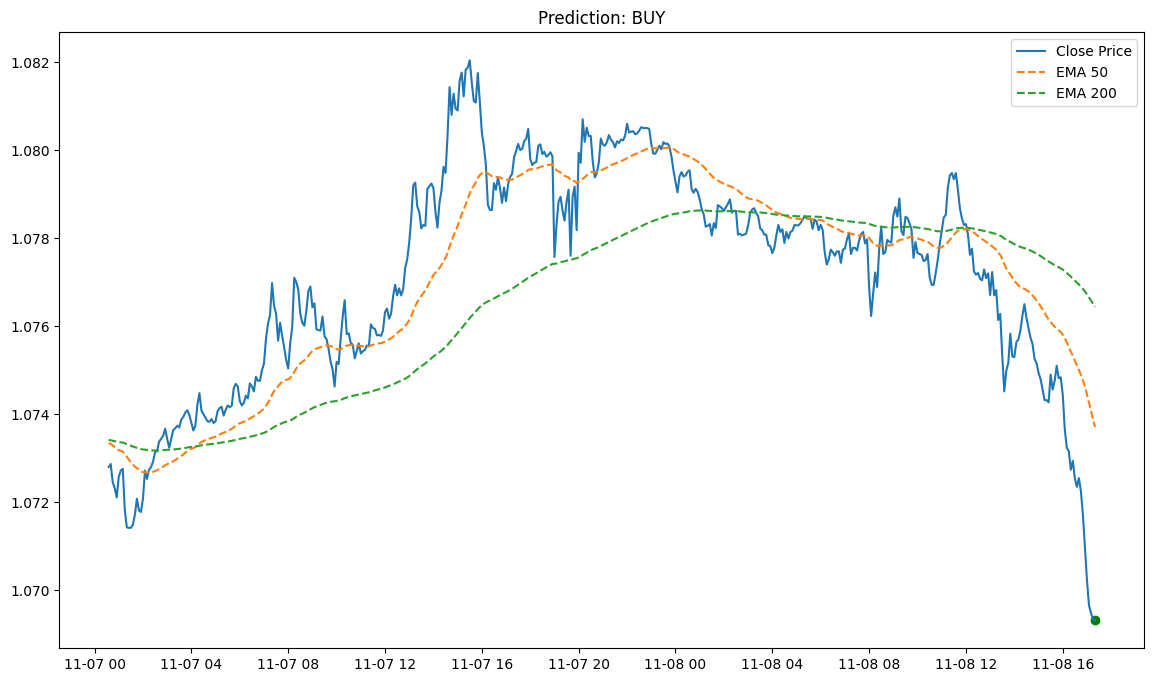

Prediction: BUY
Fetching and analyzing data...


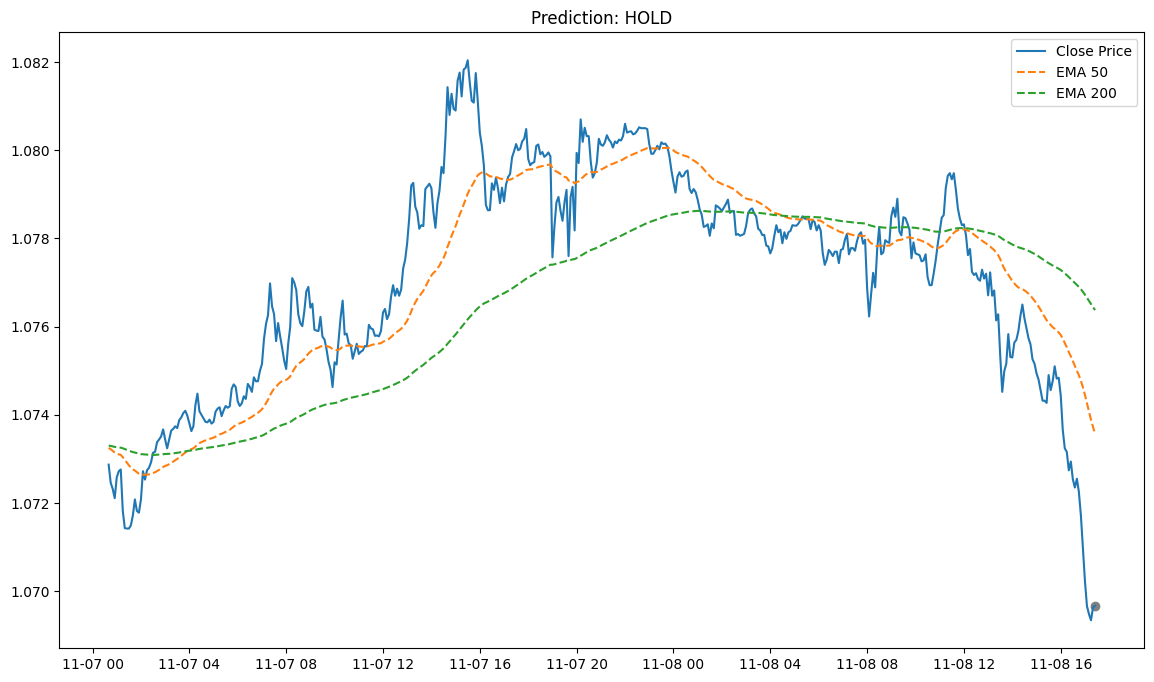

Prediction: HOLD
Fetching and analyzing data...


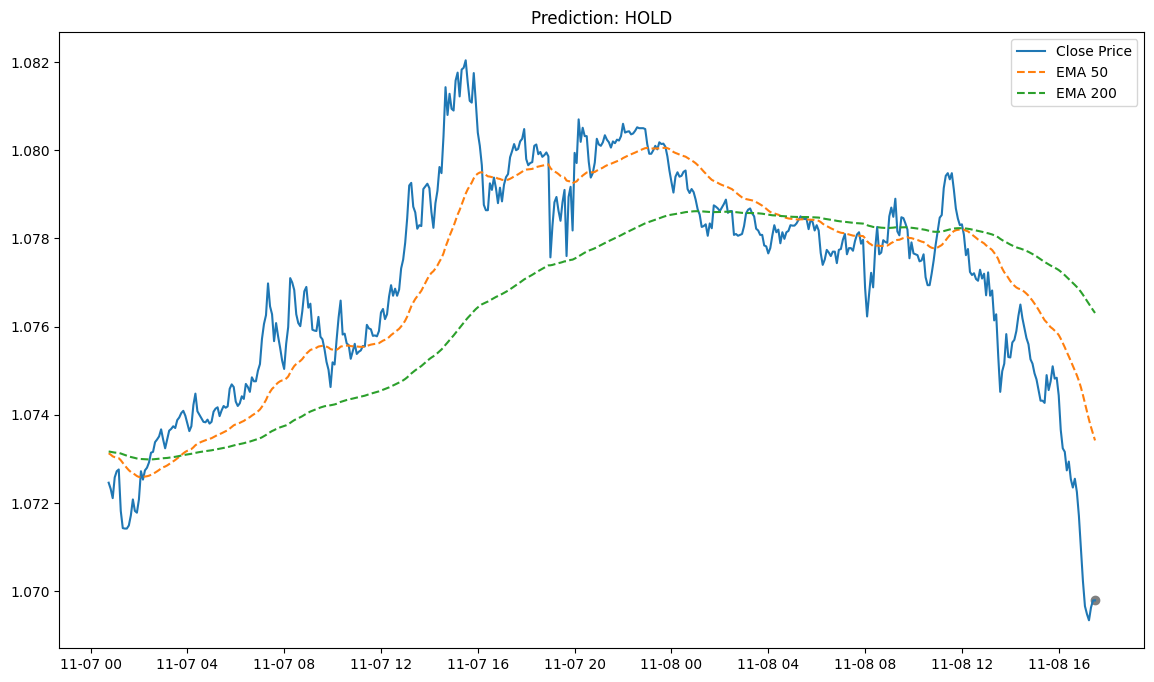

Prediction: HOLD
Fetching and analyzing data...


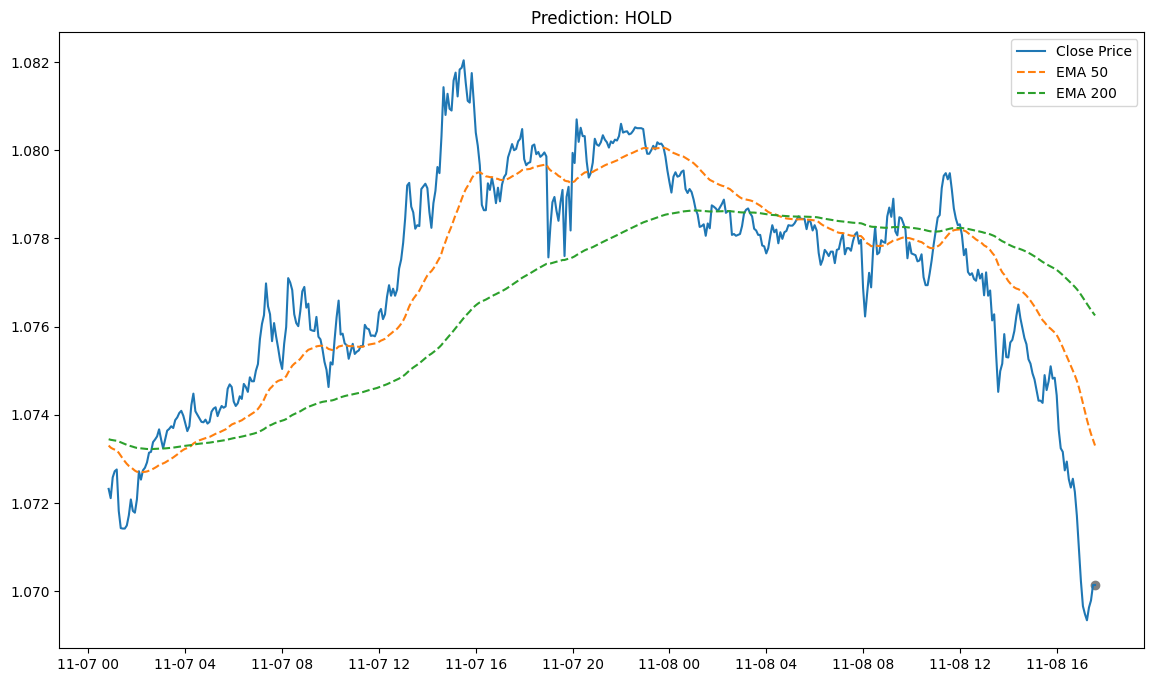

Prediction: HOLD
Fetching and analyzing data...


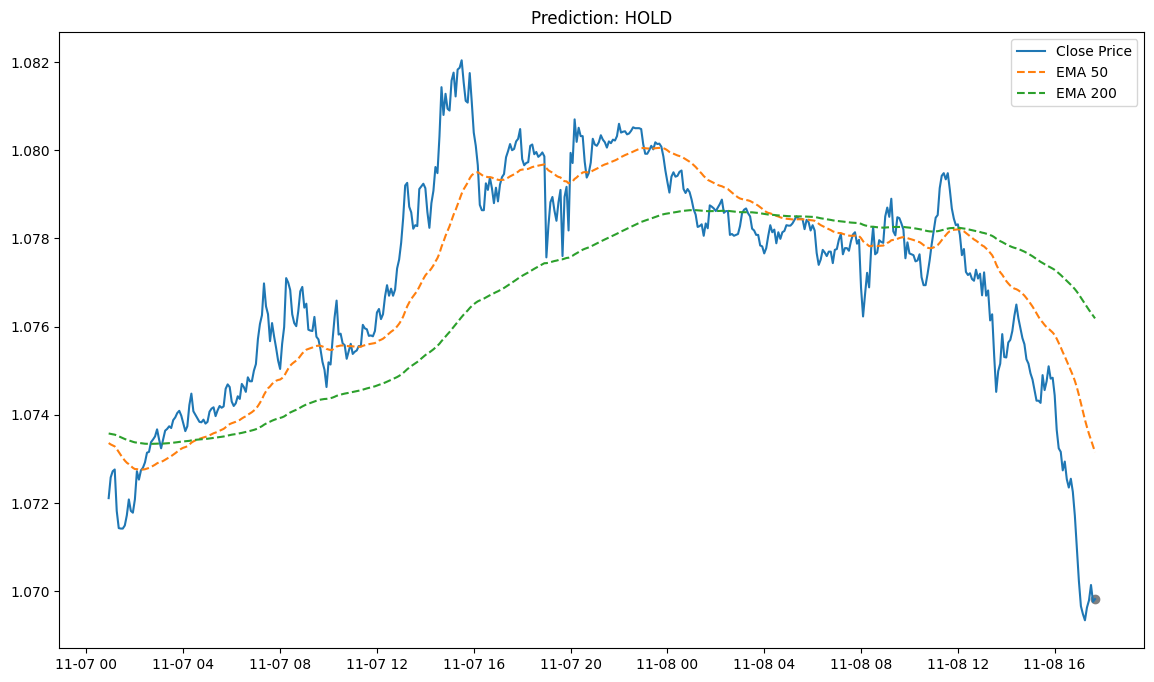

Prediction: HOLD
Fetching and analyzing data...


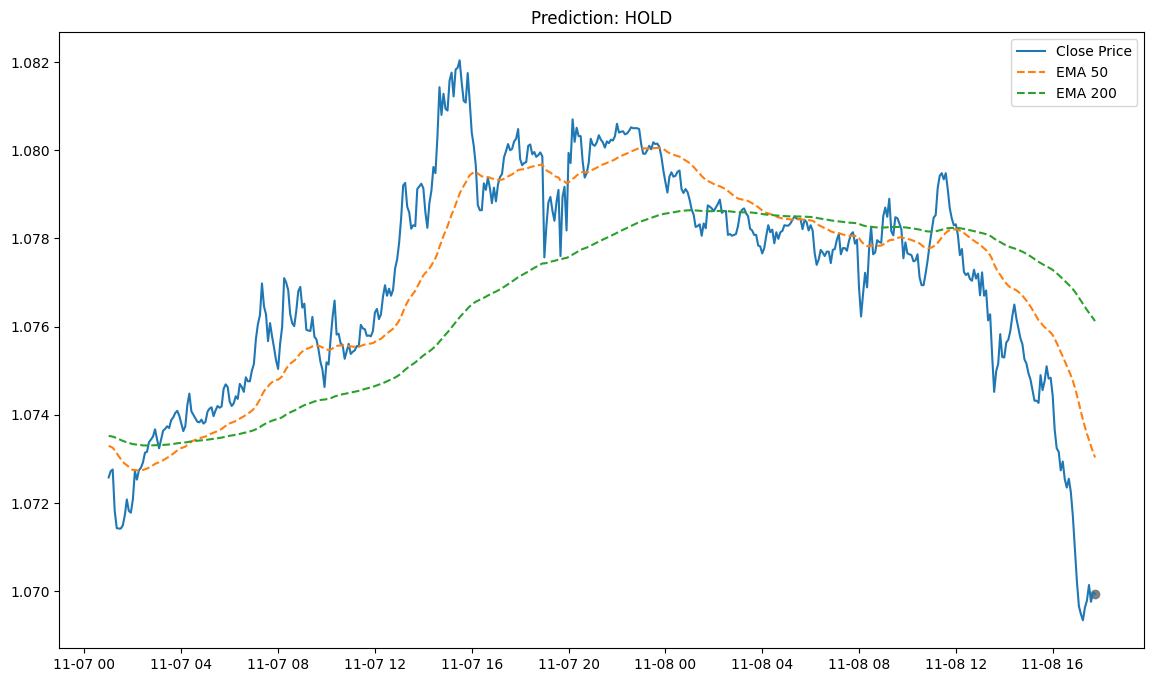

Prediction: HOLD
Fetching and analyzing data...


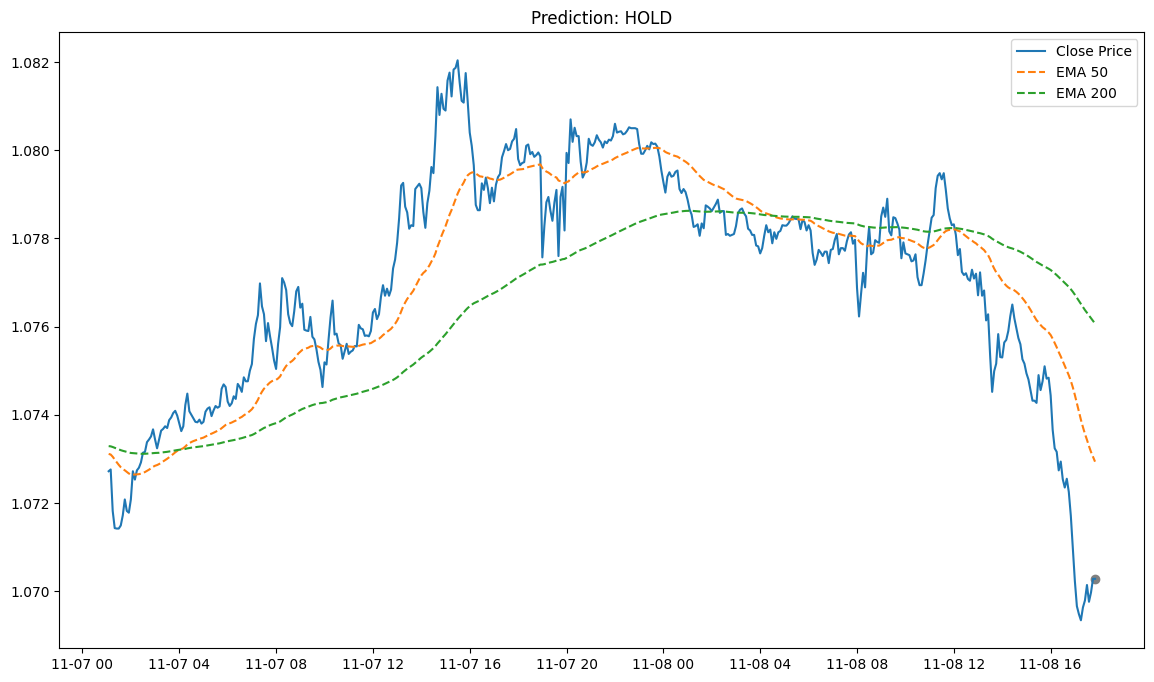

Prediction: HOLD
Fetching and analyzing data...


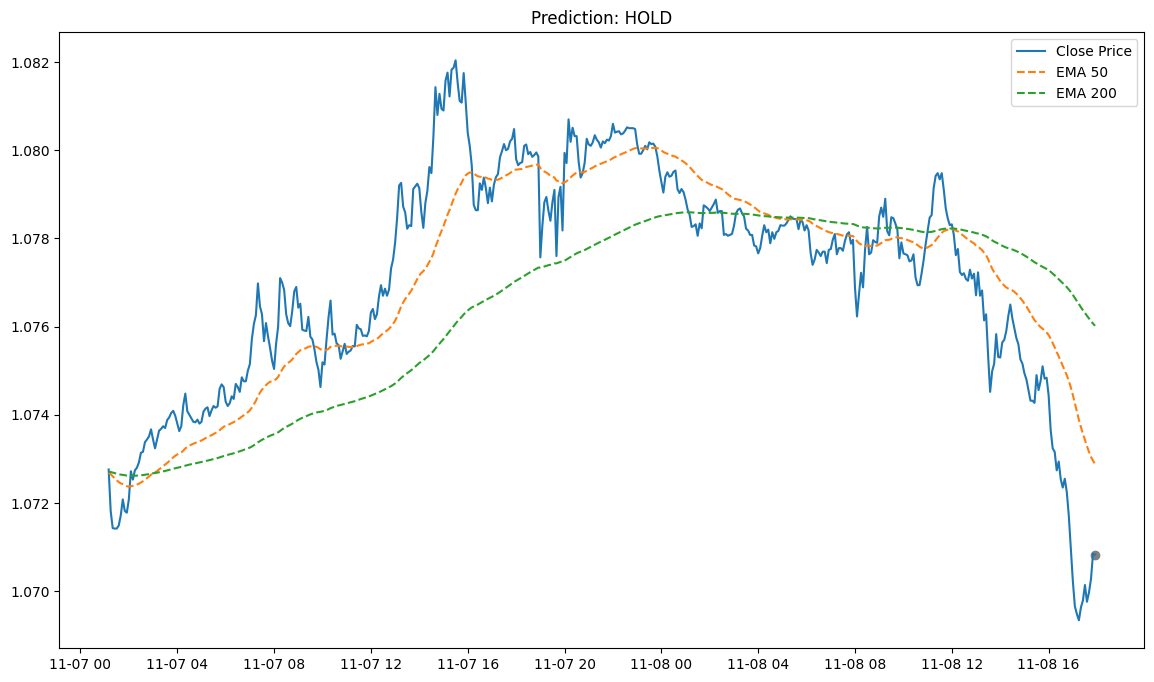

Prediction: HOLD
Fetching and analyzing data...


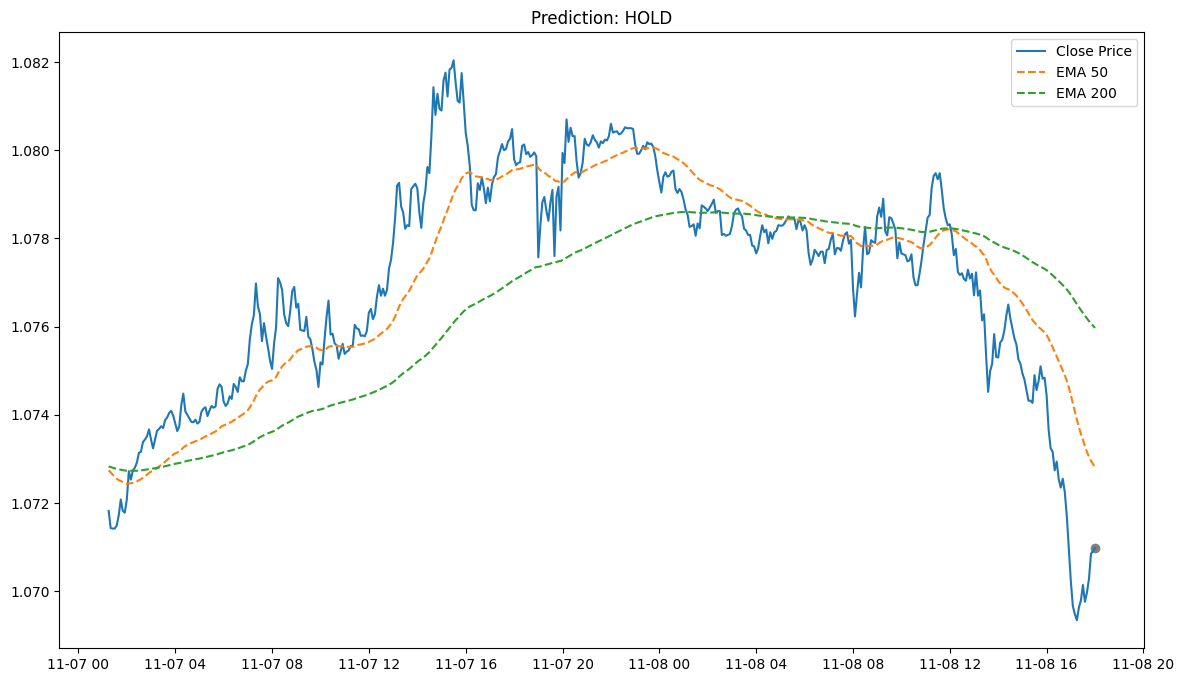

Prediction: HOLD
Fetching and analyzing data...


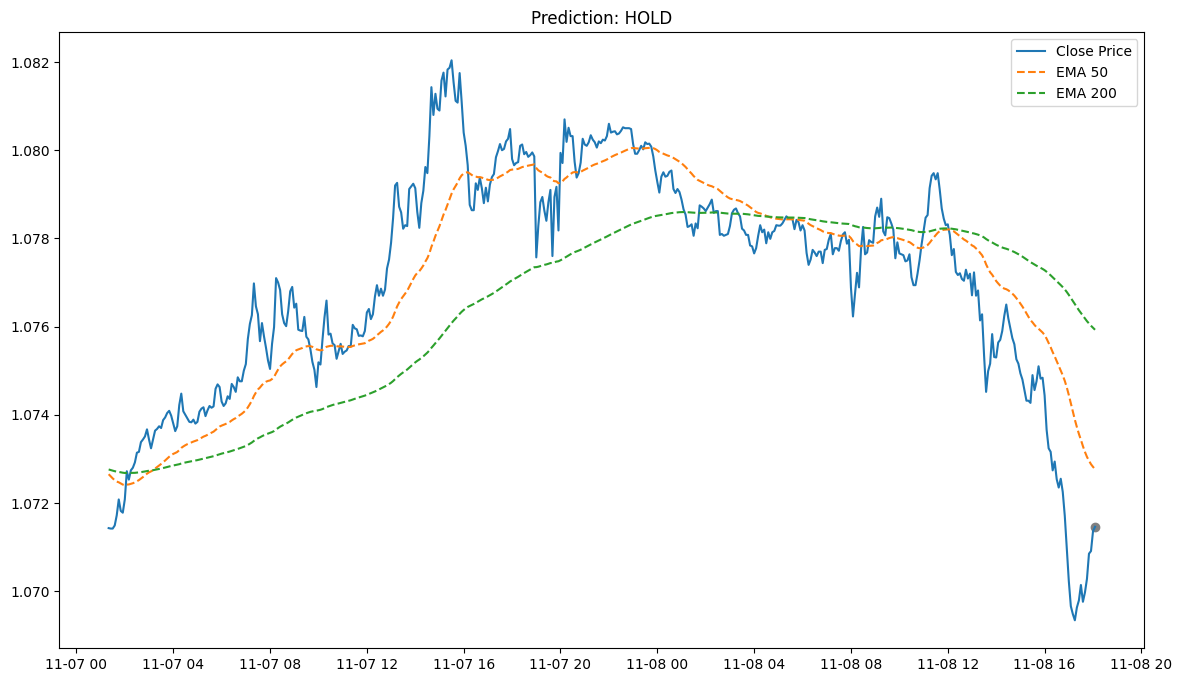

Prediction: HOLD
Fetching and analyzing data...


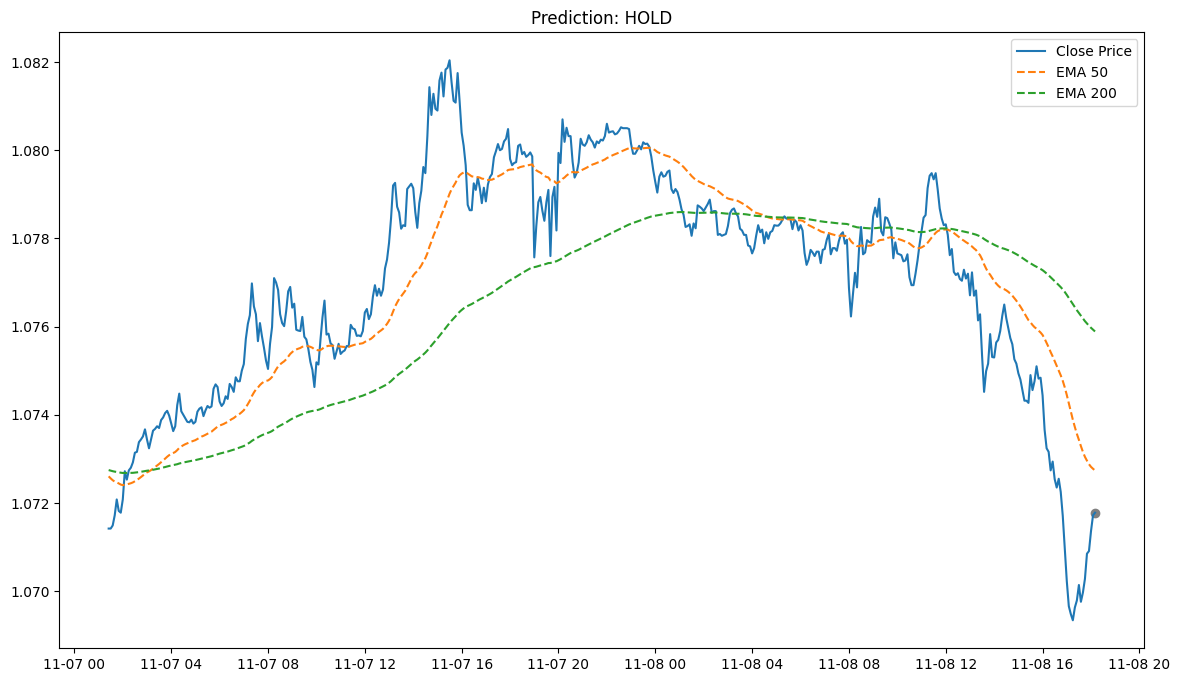

Prediction: HOLD
Fetching and analyzing data...


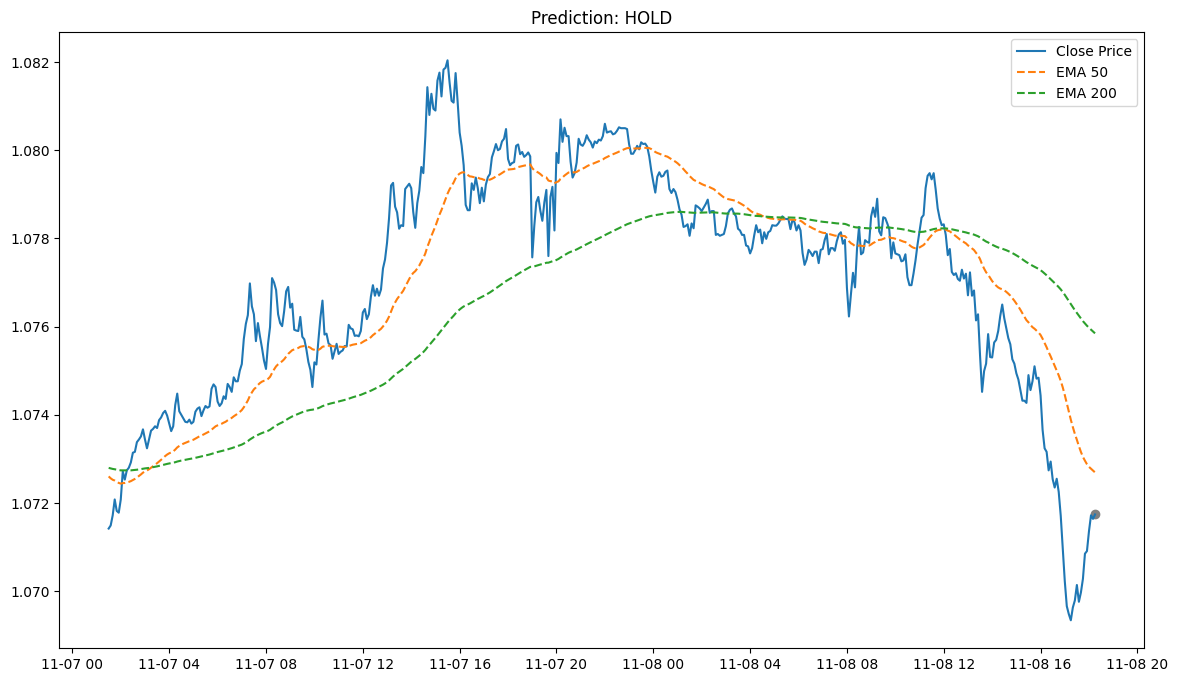

Prediction: HOLD
Fetching and analyzing data...


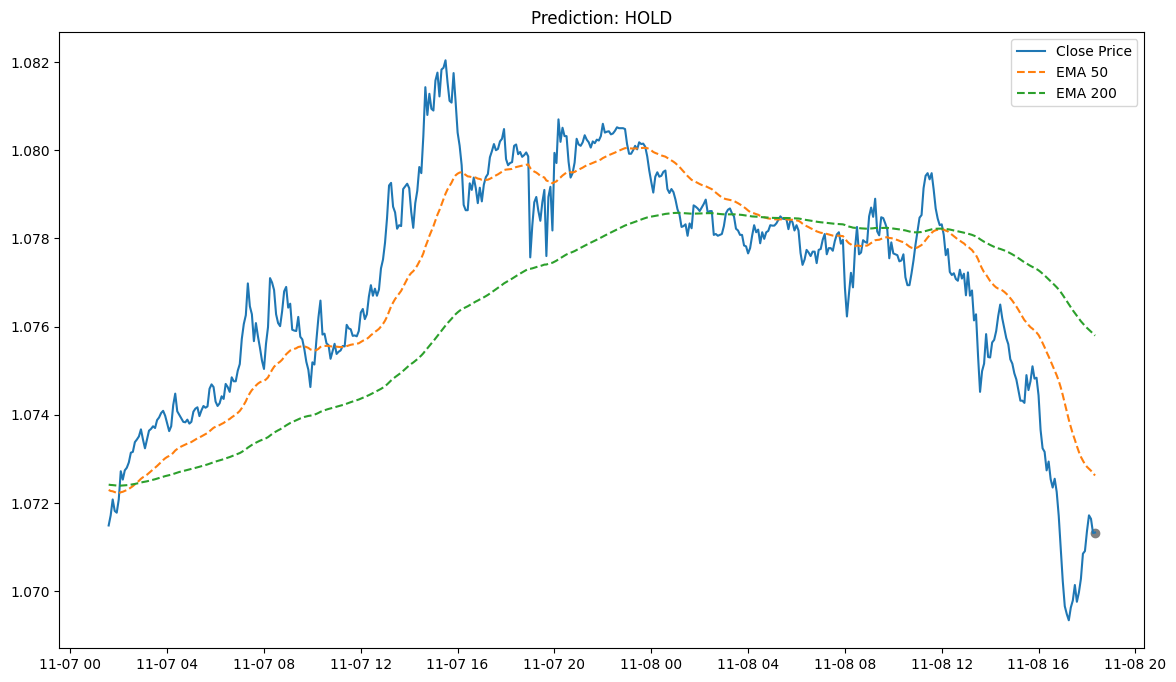

Prediction: HOLD
Fetching and analyzing data...


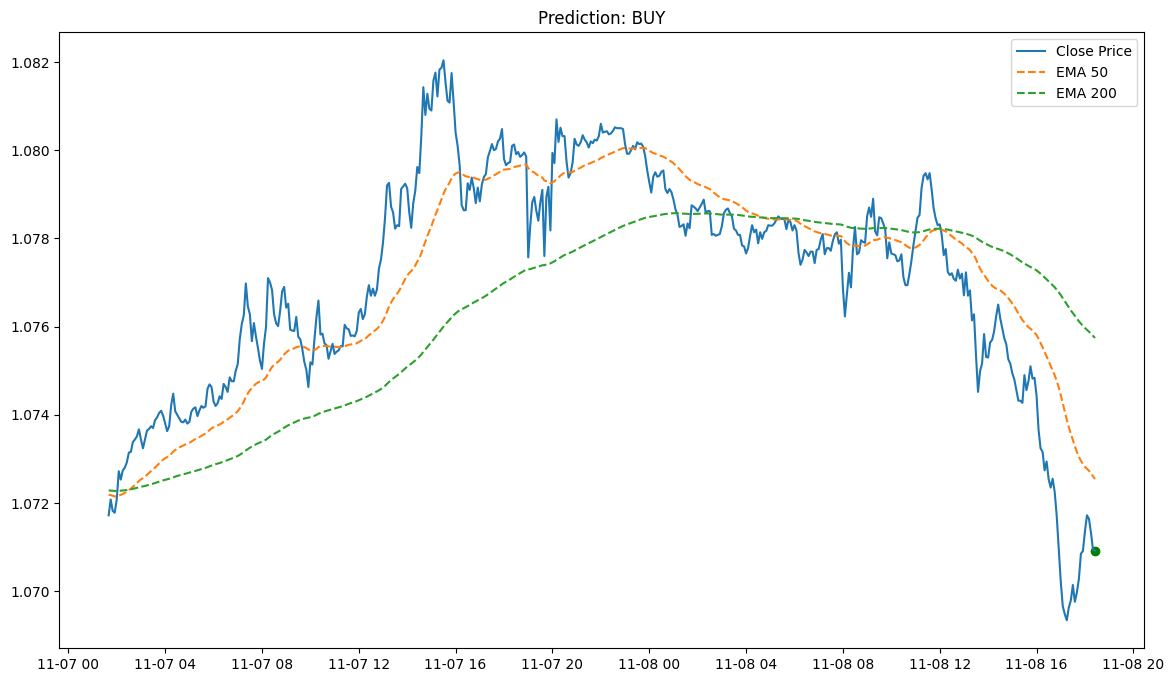

Prediction: BUY
Fetching and analyzing data...


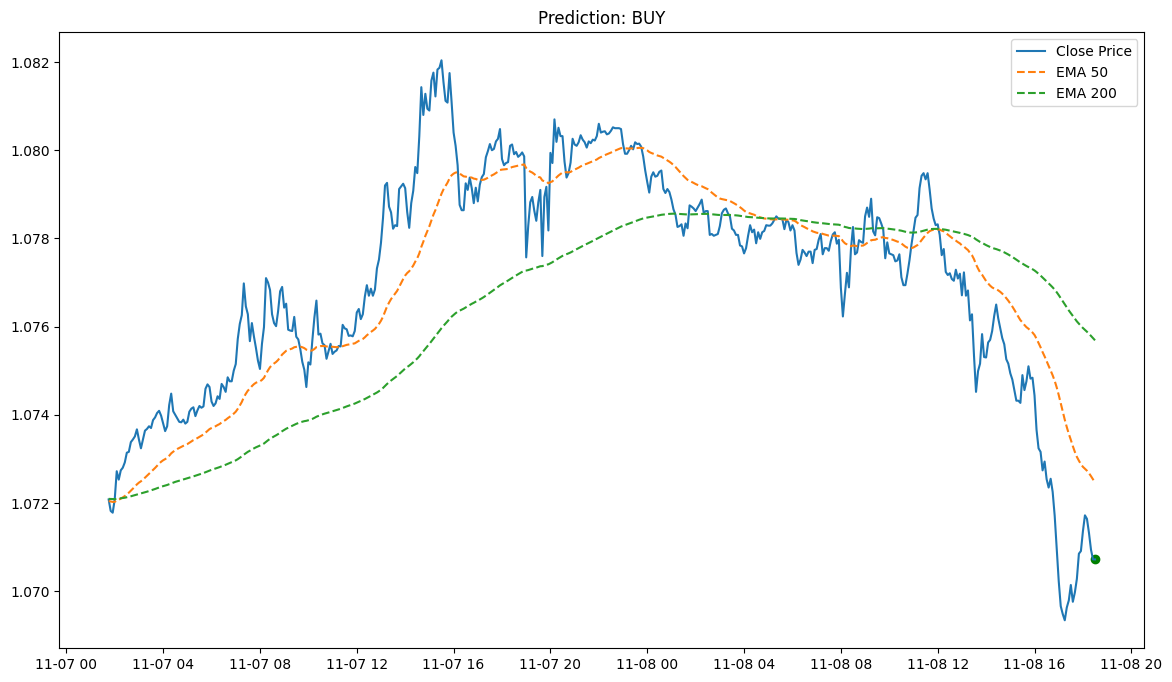

Prediction: BUY
Fetching and analyzing data...


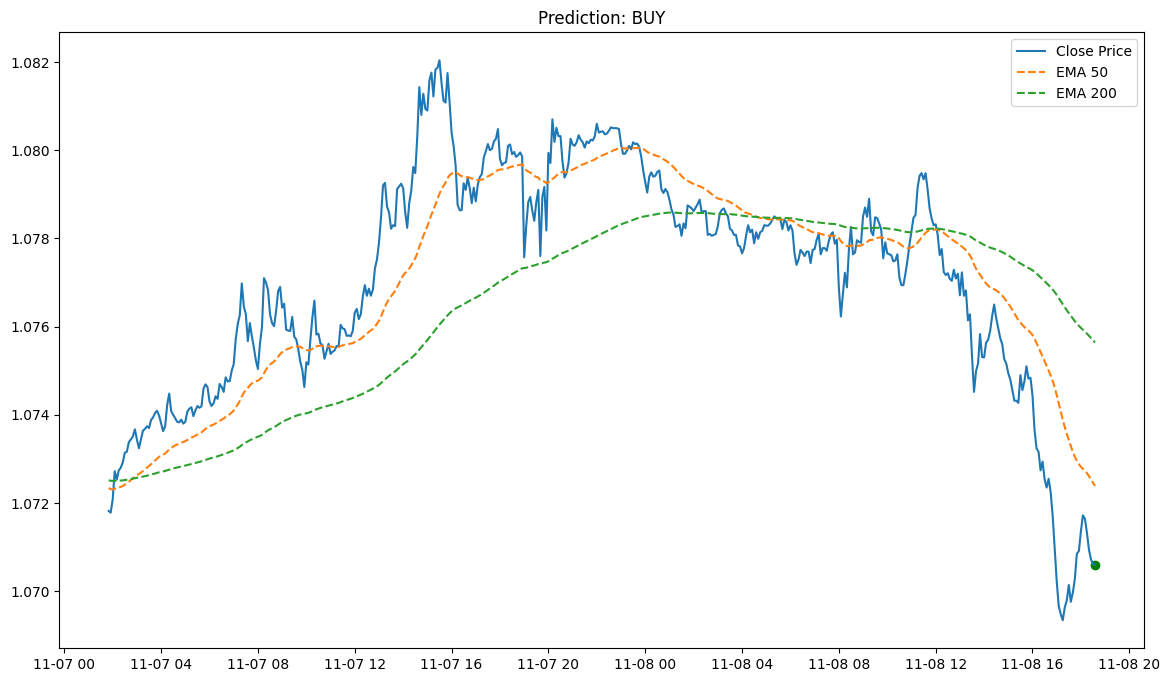

Prediction: BUY
Fetching and analyzing data...


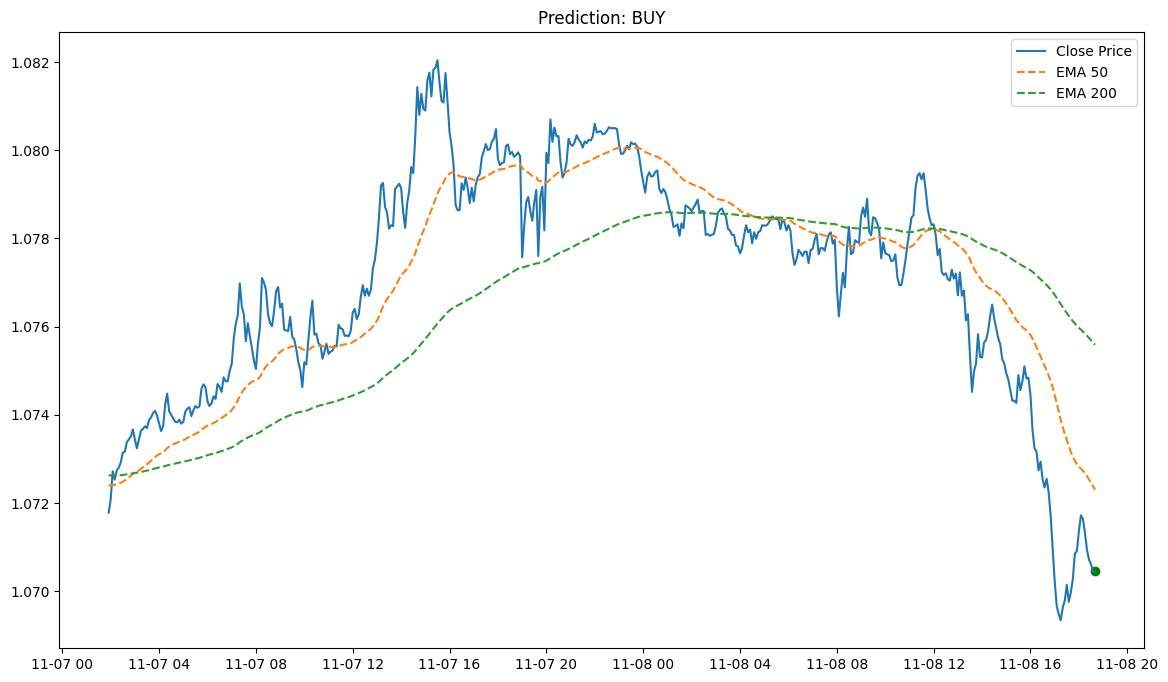

Prediction: BUY
Fetching and analyzing data...


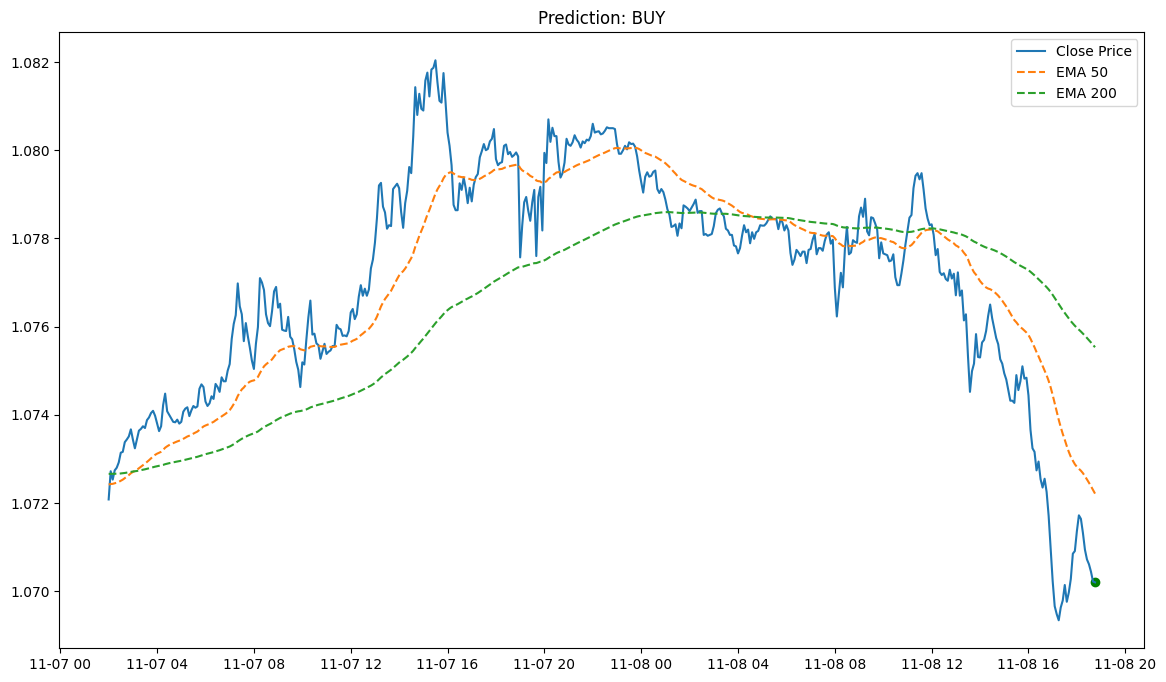

Prediction: BUY
Fetching and analyzing data...


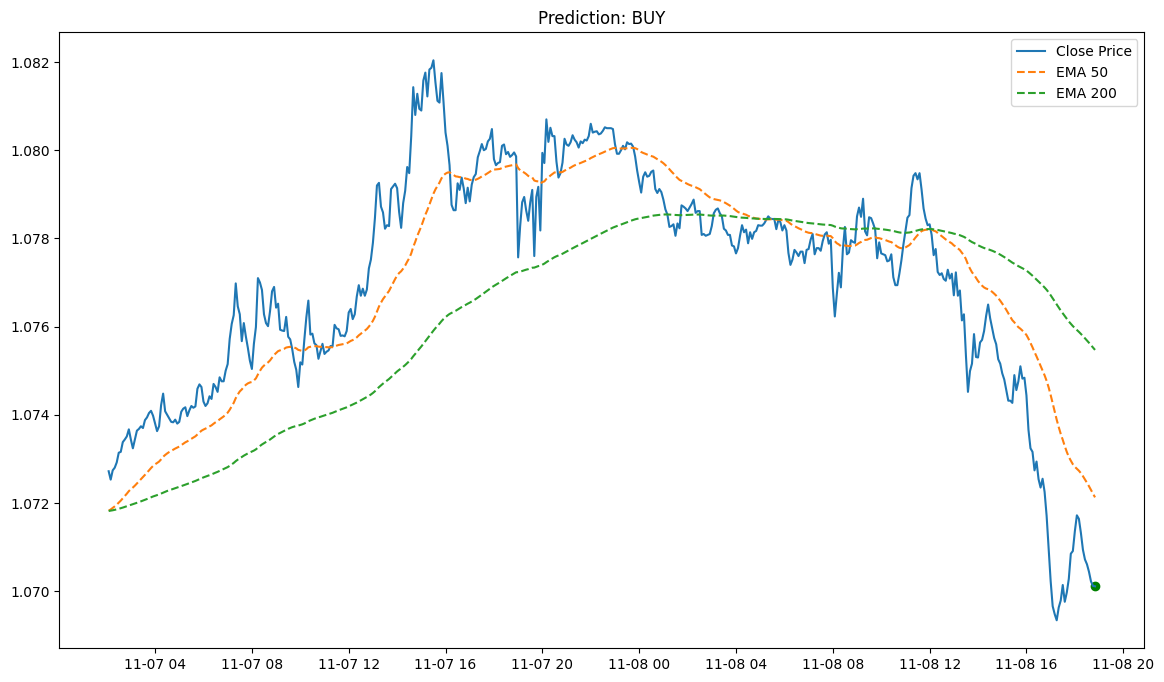

Prediction: BUY
Fetching and analyzing data...


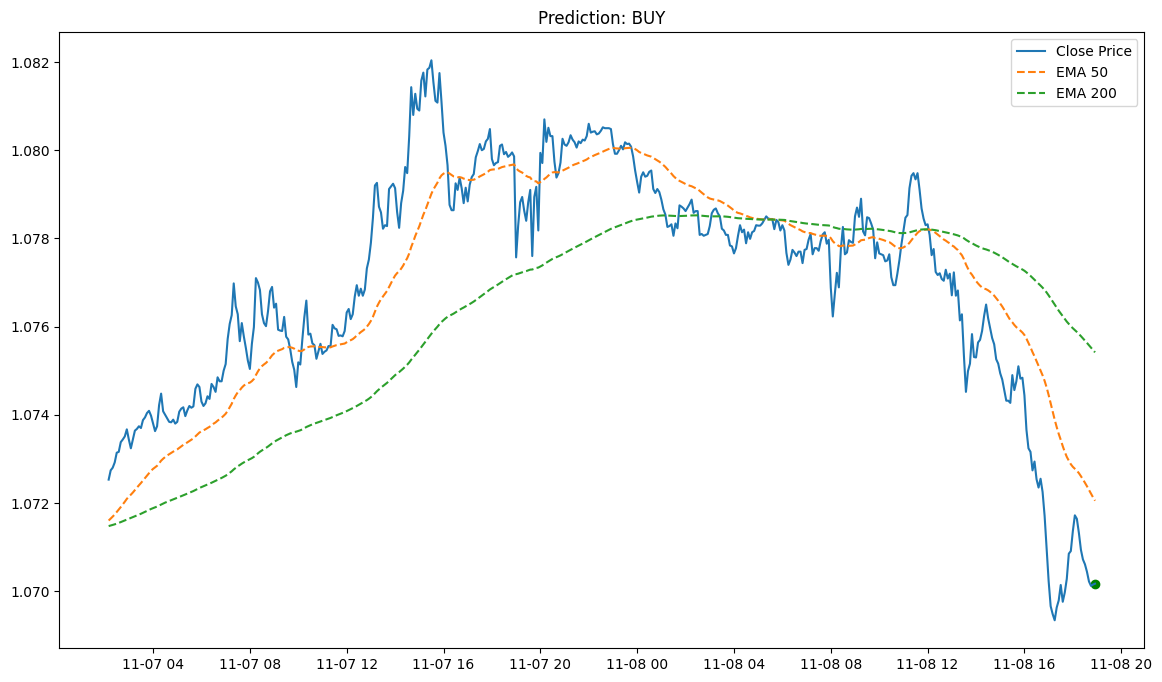

Prediction: BUY
Fetching and analyzing data...


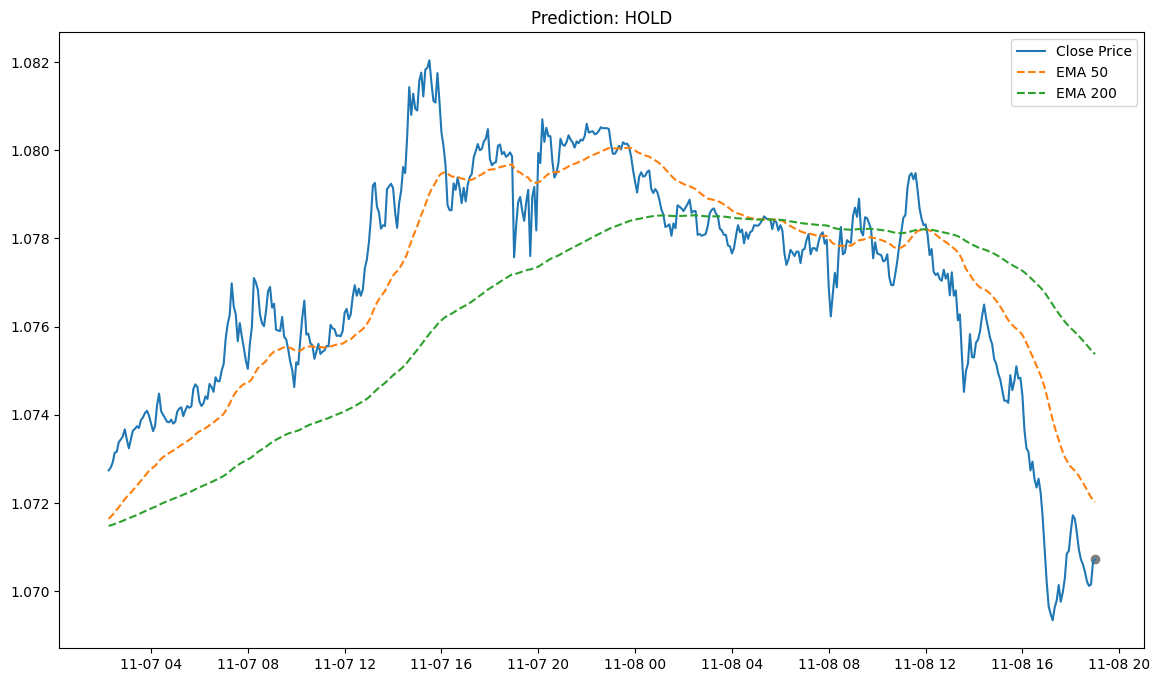

Prediction: HOLD
Fetching and analyzing data...


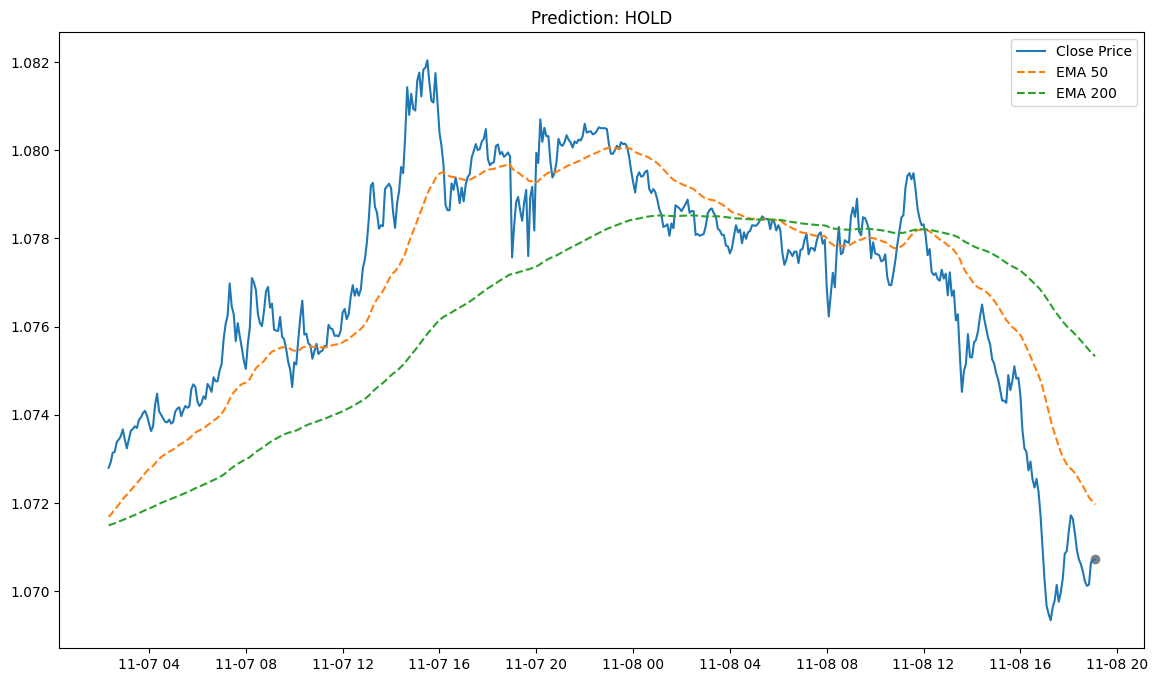

Prediction: HOLD
Fetching and analyzing data...


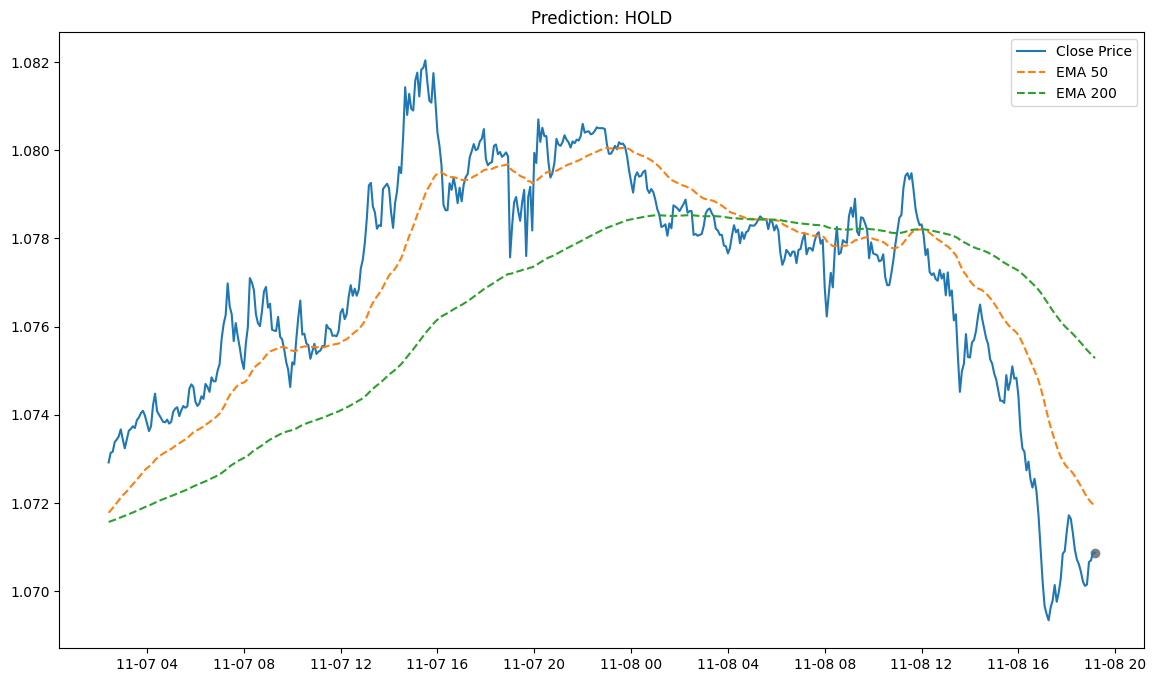

Prediction: HOLD


In [ ]:
import time

while True:
    print("Fetching and analyzing data...")
    df = fetch_price_data("EUR_USD", "M5")
    df = calculate_features(df)
    prediction = predict_and_plot(df)
    print(f"Prediction: {'BUY' if prediction == 1 else 'SELL' if prediction == -1 else 'HOLD'}")
    time.sleep(300)  # Wait 5 minutes before the next prediction
